머신러닝 알고리즘들은 좋은 성능을 내기 위해 매개변수를 조정하고 훈련하는 과정을 반복한다
반면에 딥러닝에서는 모델의 구조를 직접 만든다는 느낌이 훨씬 강하다
층을 추가하고 층에 있는 뉴런의 개수와 활성화 함수를 결정하는 것처럼...
---
패션 MNIST 데이터셋을 적재하고 훈련 세트와 검증 세트로 나눈다

In [1]:

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

모델을 만드는 간단한 함수를 정의한다
if 구문의 역할은 model_fn() 함수에 keras층을 추가하면 은닉층 뒤에 또 하나의 층을 추가한다

In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model
model = model_fn()

c:\Users\82108\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


이번에는 fit() 메서드의 결과를 history 변수에 담아보자

In [7]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [8]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


케라스는 기본적으로 에포크마다 손실을 계산한다
정확도는 compile에서 accuracy를 추가했기 때문에 history 속성에 포함되어있다
---
### 검증 손실
에포크에 대한 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증세트에 대한 점수도 필요하다
따라서 훈련 세트의 손실만 그려서는 안 된다
#### 인공신경망이 최적화하는 대상은 정확도가 아닌 손실이기에 모델이 잘 훈련되었는지 판단하려면 손실 함수의 값을 확인해야 한다
#### validation data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달해야 한다

In [12]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [10]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


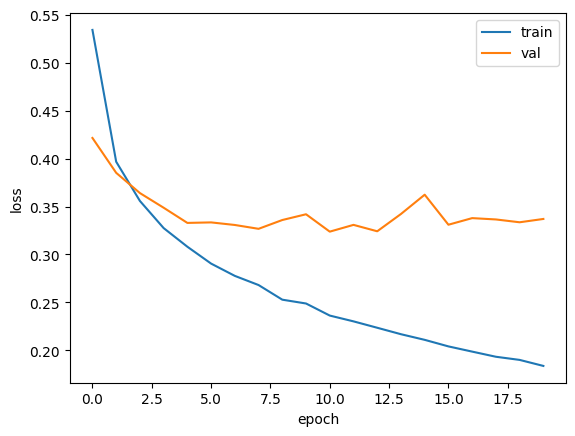

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

이번에는  옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시켜보자
지금 쓰고있는(기본적인) RMSprop 말고 Adam을 사용해보자

In [16]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

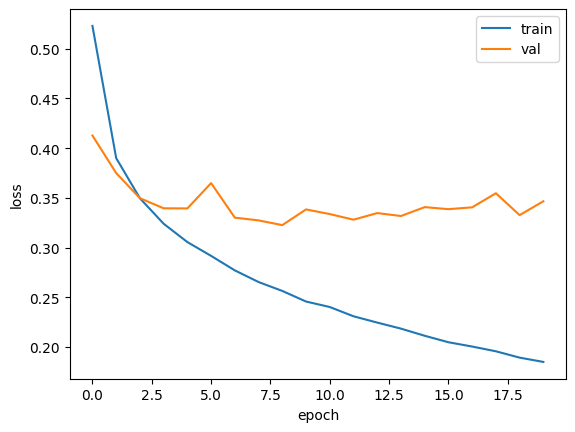

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


### 드롭아웃

훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는다

이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 주의를 기울여야 한다
일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있다
또한 이는 2개의 신경망을 앙상블 하는 것처럼 상상할 수 있다

케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다

In [18]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

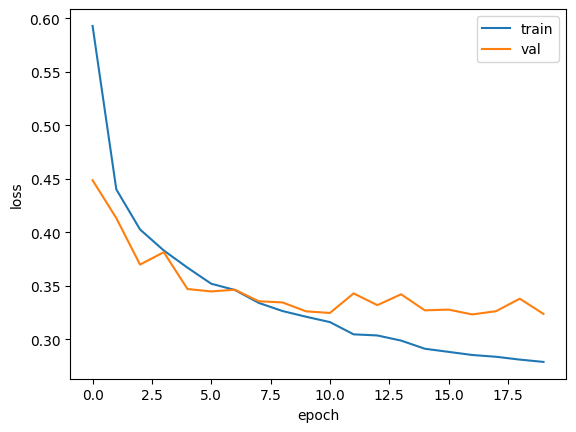

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 모델 저장과 복원
keras는 save_weights()를 통해 훈련된 모델의 파라미터를 저장한다
save()는 모델 구조와 모델 파라미터를 함께 저장한다

In [21]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

c:\Users\82108\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.save_weights('model.weights.h5')

In [26]:
model.save('model.whole.h5')

In [27]:
!ls -al *.h5

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [28]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model.weights.h5')

c:\Users\82108\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재했다
이때 사용하는 메서드는 save_weights()와 쌍을 이루는 load_weights()이다
또한 load_weights()를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 한다
keras에서 예측을 수행하는 predict() 메서드는 샘플마다 10개의 클래스에 대한 확률을 반환한다
검증 세트의 샘플 개수가 (12000,10)이었기에 predict 메서드는 (12000,10) 크기의 배열을 반환한다

In [29]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8790833333333333


In [30]:
model = keras.models.load_model('model.whole.h5')

model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8795 - loss: 0.3242


[0.32561734318733215, 0.8790833353996277]

### 모델을 두 번 훈련하지 않고 한번에 끝낼 수 없을까?
## 콜백
훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체
ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다
save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다

In [34]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5.keras',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

c:\Users\82108\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model = keras.models.load_model('best-model.h5.keras')

model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8888 - loss: 0.3131


[0.3112037181854248, 0.8854166865348816]

#### 조기 종료를 위한 Early Stopping
patience 지정으로 몇번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다
restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])